In [2]:

import torch
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.data import Data
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric_temporal.signal import DynamicGraphTemporalSignal
from torch_geometric_temporal.signal import temporal_signal_split
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN
from torch_geometric.data import Dataset
import numpy as np
import pandas as pd
import haversine as hs
import math
import math

import datetime as dt
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
import seaborn as sns
import torch.nn as nn
from torch_geometric_temporal.nn.recurrent import TGCN
from torch_geometric.nn import GATConv



rho = 165.0


In [4]:
df=pd.read_csv('Untitled Folder/On_Time_Reporting_January_2023.csv')
airports_sub = pd.read_csv('Untitled Folder/us-airports.csv')
air_zone=pd.read_csv("Untitled Folder/optd_por_public_modded.csv")


In [5]:
##UTILITY...Suppossedly. Also contains methods used to chunk data processing. 

In [44]:
class Position:
    def __init__(self, longitude, latitude, altitude):
        self.longitude = longitude
        self.latitude = latitude
        self.altitude = altitude

    def get_longitude(self):
      return self.longitude

    def get_latitude(self):
      return self.latitude

    def get_altitude(self):
      return self.altitude

def find_T_Group(date):
    initial = datetime(year = 2023, month = 1, day = 1, hour = 0, minute = 0, second = 0)
    conv_time = pd.Timestamp.to_pydatetime(date)
    delta = conv_time - initial
    grouping = math.floor(math.floor(delta.total_seconds() / 60) / 15)
    return grouping

def combine_date_time(date, military_time, zone_offset):

    ##Here we could add a check for DST
    zone_offset=dt.timedelta(minutes = int(zone_offset*60))
    str_date = datetime.strptime(date, '%m/%d/%Y %I:%M:%S %p')
    hours, minutes = divmod(military_time, 100)
    mil_time_minutes = 60*hours + minutes

    time_change = dt.timedelta(minutes = int(mil_time_minutes))
    corrected_time = str_date + time_change+zone_offset
    return corrected_time

def clean_airports(airports_sub):
    airports_sub = airports_sub[airports_sub["type"].isin(["large_airport", "medium_airport"])]
    
    airports_sub = airports_sub[(airports_sub["name"].str.contains("Base") == False) |
                                        ((airports_sub["name"].str.contains("Base") == True) &
                                         (airports_sub["name"].str.contains("/") == True))]
    
    airports_sub = airports_sub[(airports_sub["name"].str.contains("Landing") == False)]
    
    airports_sub = airports_sub[(airports_sub["name"].str.contains("Airfield") == False) |
                        ((airports_sub["name"].str.contains("Airfield") == True) &
                        (airports_sub["name"].str.contains("Regional") == True))]
    
    airports_sub = airports_sub[(airports_sub["name"].str.contains("Naval") == False)]
    
    airports_sub = airports_sub[(airports_sub["name"].str.contains("Miramar") == False)]
    
    airports_sub = airports_sub[(airports_sub["ident"].str.contains("US-") == False) |
                        (airports_sub["ident"].str.contains("US-0571") == True)]
    
    airports_sub = airports_sub[(airports_sub["name"].str.contains("LRRS") == False)]
    
    airport_list = airports_sub[["iata_code", "latitude_deg", "longitude_deg", "elevation_ft"]]
    airport_list=airport_list.dropna()
    
    airport_list["index"] = airport_list.reset_index().index
    airport_list = airport_list[["index", "iata_code", "latitude_deg", "longitude_deg", "elevation_ft"]]
    airport_list = airport_list.rename(columns = {"iata_code" : "ident"})
    
    return airport_list

def clean_flights(df):
    df["origin_offset"]=df.apply(lambda x: zone_dictionary.get(x["ORIGIN"]), axis=1)
    df["dest_offset"]=df.apply(lambda x: zone_dictionary.get(x["DEST"]), axis=1)
    df["DEP_DELAY_RAW"]=df["DEP_DELAY"]
    df["DEP_TIME"] = df.apply(lambda x: cancellation_dep_time_conv(x['CANCELLED'], x['CRS_DEP_TIME'], x['DEP_TIME']), axis = 1)
    
    df=df.dropna(subset=['DEP_TIME'])
    df=df.dropna(subset=['ARR_TIME'])
    df["corrected_Dep"] = df.apply(lambda x: combine_date_time(x['FL_DATE'], x['DEP_TIME'], x['origin_offset']), axis=1)
    df["corrected_Arr"] = df.apply(lambda x: combine_date_time(x['FL_DATE'], x['ARR_TIME'], x['dest_offset']), axis=1)
    
    df=df.drop(['FL_DATE', 'DEP_TIME', 'ARR_TIME'], axis=1)
    df=df.sort_values(by='corrected_Dep')
    df.reset_index(drop=True, inplace=True)
    df["T_Group"] = df.apply(lambda x: find_T_Group(x['corrected_Dep']), axis=1)
    df = df.sort_values(by=['T_Group', 'ORIGIN'])
    df=df[(df["T_Group"]>=0)]
    df["DEP_DELAY"] = df.apply(lambda x: convert_negative_dep_times(x['DEP_DELAY'], x['CANCELLED']), axis=1)
    df["DEP_DELAY"] = df.apply(lambda x: convert_negative_dep_times(x['DEP_DELAY'], x['CANCELLED']), axis=1)
    return df

def cancellation_dep_time_conv(cancelled, crs_dep_time, dep_time):
  if (cancelled == 1):
    # At future time, try adjusting T_Group to 3 hours ahead
    # return crs_dep_time + 300
    return crs_dep_time
  return dep_time

# Converting negative dep delays to 0. This was a function that we were interested in changing farther along given the time to do so
def convert_negative_dep_times(time, cancelled):
  if (cancelled == 1.0):
    return 180
  if (time < 0):
    return 0
  if (time > 400):
    return 400
  return time

def scale_data(mode, df):
    df2=df[["corrected_Dep","DEP_DELAY"]]
    df2.index=df2["corrected_Dep"]
    df2=df2["DEP_DELAY"]
    values = df2.values
    values = values.reshape((len(values), 1))
    if mode =="minmax":
        scaler = MinMaxScaler(feature_range=(0, 1))
    elif mode== "standard":
        scaler = StandardScaler()

    scaler = scaler.fit(values)
    normalized = scaler.transform(values)
    df["NORMED_DEP"]=normalized
    return df, scaler

def define_edge(df):
    ### Edge definition
    reduced_df = df[["T_Group", "ORIGIN", "DEST", "DISTANCE"]]

    # The numbers won't be exact, but they should be close. Need to investigate why some values are very very different
    reduced_df["N_DISTANCE"] = reduced_df.apply(lambda x: calc_distance(x['ORIGIN'], x['DEST']), axis = 1)

    # Use this to identify number of duplicate routes within a T_Group
    reduced_df["ROUTE"] = reduced_df["ORIGIN"] + "-" + reduced_df["DEST"]
    return reduced_df
    
        
# To calculate distance between airports
def calc_distance(origin, destination):
  if(origin==destination):
      return 1999999
  pos1 = airport_dictionary.get(origin)
  pos2 = airport_dictionary.get(destination)

  if (pos1 is None or pos2 is None):
    return None
  loc1 = (pos1.get_latitude(), pos1.get_longitude())
  loc2 = (pos2.get_latitude(), pos2.get_longitude())
  return hs.haversine(loc1, loc2) * 0.621371

## This can be done in one function and one line with a function called zip, but I'm struggling to put it together
## properly
def get_long(origin):
  pos = airport_dictionary.get(origin)
  if (pos is None):
    return None
  return pos.get_longitude()

def get_lat(origin):
  pos = airport_dictionary.get(origin)
  if (pos is None):
    return None
  return pos.get_latitude()

def get_alt(origin):
  pos = airport_dictionary.get(origin)
  if (pos is None):
    return None
  return pos.get_altitude()


def applyIQR(dfplot):
    Q1 = np.percentile(dfplot['DEP_DELAY'], 1, method='midpoint')
    Q3 = np.percentile(dfplot['DEP_DELAY'], 99.5, method='midpoint')
    IQR = Q3 - Q1
    print("old shape:",dfplot.shape)
    Q1 = dfplot['DEP_DELAY'] .quantile(0.15)
    Q3 = dfplot['DEP_DELAY'] .quantile(0.85)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
 
    # Create arrays of Boolean values indicating the outlier rows
    upper_array = np.where(dfplot['DEP_DELAY'] >= upper)[0]
    lower_array = np.where(dfplot['DEP_DELAY'] <= lower)[0]
 
    # Removing the outliers
    dfplot.drop(index=upper_array, inplace=True)
    dfplot.drop(index=lower_array, inplace=True)
    print("new shape:",dfplot.shape)
    return dfplot

def explore(df):
    dfplot=df[["DEP_DELAY", "corrected_Dep", "NORMED_DEP", "ORIGIN","DEP_DELAY_RAW"]]
    dfplot.index=df["corrected_Dep"]
    dfplot = df.drop('corrected_Dep', axis=1)
    
    dfplot['DEP_DELAY'].plot()
    dfplot.plot(subplots=True, figsize=(25, 25))
    plt.hist(dfplot["DEP_DELAY"])
    plt.show()
    window_size = 2000
    rolling_mean = dfplot['DEP_DELAY'].rolling\
            (window_size).mean()
    rolling_mean_raw = dfplot['DEP_DELAY_RAW'].rolling\
            (window_size).mean()
    plt.plot(dfplot.index, rolling_mean, label="DEP_DELAY")
    plt.plot(dfplot.index, rolling_mean_raw, label="DEP_DELAY_RAW")
    plt.show()
    dfplot["DEP_DELAY"].plot(kind='kde')
    plt.show()
    sns.boxplot(dfplot['DEP_DELAY'])
    # Scatter plot
    fig, ax = plt.subplots(figsize=(25, 25))
    ax.scatter(dfplot['DEP_DELAY'], dfplot.index)
 
    # x-axis label
    ax.set_xlabel('(delay)')
 
    # y-axis label
    ax.set_ylabel('(time)')
    plt.show()

# Attaches an id to the airport. I sort of cheat here and use an index tab where I know there's a 1 - 1 relationship.
# It appears that all airport numeric IDs in each data set are arbitrary anyways which is interesting.
def get_index_id(origin):
  ind = airport_indexes.get(origin)
  if (ind is None):
    return None
  return ind

def combiner(df):
    ### Output for group_by actions is a Pandas Series
    
    ## To find average delay at time T for each node
    
    ## Change to the Origin ID later, I used ORIGIN because it's easier to distinguish intended functionality
    
    # All values should have a 1 to 1 relationship between airport_T_group_delays and airport_T_group_num_flights
    # For the delay at each airport at time T
    #DELETEME IF USING NON NORMED
    dfnormed = df.drop('DEP_DELAY', axis=1)
    
    aggregated_origin = dfnormed.groupby(["T_Group","ORIGIN"])
    
    
    #GONNA TRY NORMALIZING
    
    #airport_T_group_delays = aggregated_origin["DEP_DELAY"].sum().reset_index().rename(columns = {"DEP_DELAY" : "CUM_DELAY"})
    airport_T_group_delays = aggregated_origin["NORMED_DEP"].sum().reset_index().rename(columns = {"NORMED_DEP" : "CUM_DELAY"})
    
    # For collecting the number of flights that took off from each airport
    T_grouping = dfnormed.groupby(["T_Group"])
    airport_T_group_num_flights = T_grouping["ORIGIN"].value_counts(sort = False)
    airport_T_group_num_flights = airport_T_group_num_flights.to_frame().rename(columns = {"count" : "COUNT"}).reset_index()    
    airport_T_group_num_flights = airport_T_group_num_flights.rename(columns = {"ORIGIN" : "ORIGINb", "T_Group" : "T_Groupb"})
    combined = pd.concat([airport_T_group_delays, airport_T_group_num_flights], axis = 1)
    combined = combined[["T_Group", "ORIGIN", "CUM_DELAY", "COUNT"]]  
    # Calculating the Average Delay for a node within a T_Group
    combined["AVG_DELAY"] = combined["CUM_DELAY"] / combined["COUNT"] 
    # Adding the position data via the Dictionary
    combined["LONGITUDE"] = combined.apply(lambda x: get_long(x['ORIGIN']), axis=1)
    combined["LATITUDE"] = combined.apply(lambda x: get_lat(x['ORIGIN']), axis=1)
    combined["ALTITUDE"] = combined.apply(lambda x: get_alt(x['ORIGIN']), axis=1)
    # Subsetting to remove locations with null position data. It's technically safer to check all three, but because of the way
    # our airport data set was structured, if one is missing, then they're all missing. So we can be a tiny bit more efficient
    # by checking against just one column.
    combined = combined[(combined["ALTITUDE"].isnull() == False)]
    # combined = combined[(combined["LONGITUDE"].isnull() == False)]
    # combined = combined[(combined["LATITUDE"].isnull() == False)]
    
    
    combined["AIR_ID"] = combined.apply(lambda x: get_index_id(x['ORIGIN']), axis = 1)
    
    combined = combined[(combined["AIR_ID"].isnull() == False)]
    
    combined = combined[["T_Group", "AIR_ID", "AVG_DELAY","COUNT", "LONGITUDE", "LATITUDE", "ALTITUDE"]]
    # This should be very close to the structure of the x input after we convert to a torch tensor. Need to do another
    # group_by when every thing is collected.
    return combined

### Edge Embedding
def get_origin_from_route(route):
  return route[0:3]

def get_dest_from_route(route):
  return route[4:]
def group_edges(reduced_df):
    edge_grouping = reduced_df.groupby(["T_Group"])["ROUTE"].value_counts().to_frame().rename(columns = {"count" : "COUNT"}).reset_index()
    edge_grouping["ORIGIN"] = edge_grouping.apply(lambda x: get_origin_from_route(x['ROUTE']), axis = 1)
    edge_grouping["DEST"] = edge_grouping.apply(lambda x: get_dest_from_route(x['ROUTE']), axis = 1)
    
    edge_grouping["ORIGIN_ID"] = edge_grouping.apply(lambda x: get_index_id(x['ORIGIN']), axis = 1)
    edge_grouping["DEST_ID"] = edge_grouping.apply(lambda x: get_index_id(x['DEST']), axis = 1)
    
    edge_grouping = edge_grouping.sort_values(by = ["T_Group", "ORIGIN_ID", "DEST_ID"])
    
    edge_grouping["DISTANCE"] = edge_grouping.apply(lambda x: calc_distance(x['ORIGIN'], x['DEST']), axis = 1)
    edge_grouping = edge_grouping[["T_Group", "COUNT", "DISTANCE"]]
    
    # Now need to encode Route and this should(?) function as edge embedding input
    return edge_grouping
def more_reducing(reduced_df):
    reduced_df["ORIGIN_ID"] = reduced_df.apply(lambda x: get_index_id(x['ORIGIN']), axis = 1)
    reduced_df["DEST_ID"] = reduced_df.apply(lambda x: get_index_id(x['DEST']), axis = 1)
    
    reduced_df = reduced_df.sort_values(by = ["T_Group", "ORIGIN_ID", "DEST_ID"])
    return reduced_df
def create_empty_df():
    empty_df = pd.DataFrame(columns = ["AIR_ID", "AVG_DELAY", "COUNT", "LONGITUDE", "LATITUDE", "ALTITUDE"])
    
    for aport in airport_dictionary.keys():
      empty_airport = {"AIR_ID": np.int64(airport_indexes.get(aport)), "AVG_DELAY" : 0.000000, "LONGITUDE" : get_long(aport),
                       "LATITUDE" : get_lat(aport), "ALTITUDE" : get_alt(aport)}
      empty_data = pd.DataFrame([empty_airport])
      empty_df = pd.concat([empty_df, empty_data], axis = 0, ignore_index = True)
    empty_df["COUNT"]=0
    empty_df["COUNT"]=np.int64(empty_df["COUNT"])
    
    return empty_df



def fill_na(check):
  if (np.isnan(check) == True):
    return 0
  return check

def remove_common(a, b):
  a = [i for i in a if i not in b]


import matplotlib.pyplot as plt
import numpy as np


def plotGraph(i,regressorName, predictions, test_dataset):
    y=predictions[i]
    x=test_dataset[i].y.view(-1, 1).tolist()
    y=np.array(y)
    y=np.vstack(y)
    x=scaler.inverse_transform(x)

    y=scaler.inverse_transform(y)
    y_test = x
    y_pred = y
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
    plt.scatter(range(len(y_test)), y_test, color='blue')
    plt.scatter(range(len(y_pred)), y_pred, color='red')
    plt.title(regressorName)
    plt.show()
def plotters(i,regressorName, predictions, test_dataset):    
    for i in range(0,25):
        plotGraph(i,regressorName, predictions, test_dataset)


def routercodes(origin,dest):
  o=airport_indexes.get(origin)
  d=airport_indexes.get(dest)
    
  x=str(np.int64(o))+"-"+str(np.int64(d))
  return x

def Geoneighbors():
    tryme=airport_dictionary.keys()
    tryme=pd.DataFrame(tryme, columns = ["index"])
    
    all_starts= tryme.rename(columns={"index":"start_ident"})
    all_ends=  tryme.rename(columns={"index":"end_ident"})
    distance_matrix = all_ends.merge(all_starts, how="cross")
    distance_matrix["distance"] = distance_matrix.apply(lambda x: calc_distance(x["start_ident"], x["end_ident"]),  axis=1)
    
    distance_matrix["edge"] = distance_matrix["distance"] <= rho
    edge_index_neighbor=distance_matrix[distance_matrix["edge"]==True][["start_ident", "end_ident","distance"]]
    edge_index_neighbor["start_index"]=edge_index_neighbor.apply(lambda x: airport_indexes.get(x["start_ident"]), axis=1)
    edge_index_neighbor["end_index"]=edge_index_neighbor.apply(lambda x: airport_indexes.get(x["end_ident"]), axis=1)
    edge_index_neighbor["ROUTE"]=edge_index_neighbor.apply(lambda x: routercodes(x["start_ident"], x["end_ident"]), axis=1)
    return distance_matrix, edge_index_neighbor
import math
def eudist(origin, dest):
    if math.isnan(origin):
        origin=0
    if math.isnan(dest):
        dest=0
    x=pow(origin-dest, 2)
    x=math.sqrt(x)
    if x!=0:
        x=1/x
    return x

def router(o,d):

    
  x=str(np.int64(o))+"-"+str(np.int64(d))
  return x



def checkshape(xs, edge_indices, edge_attributes, ys, out_y_indices, x):
  for i in range(0, x):
      print (i,"frame")
      print(xs[i].shape)
      print(edge_indices[i].shape)
      print(edge_attributes[i].shape)
      print(ys[i].shape)
      print(out_y_indices[i].shape)
def plotpred(predictions, actuals):
    z=[]
    for i in range(len(predictions)):
        x=(scalar.inverse_transform((np.asarray(predictions[i]).reshape(-1, 1))))
        y=(scalar.inverse_transform((np.asarray(actuals[i]).reshape(-1, 1))))
        z.append(sum(((y-x)**2))/753)
    plt.plot(z)
   

In [7]:
def OG_Edge(reduced_df, combined, empty_df):
    ### For Operational Graph
    pd.options.mode.chained_assignment = None
    ### Not the cleanest approach, I think we'd want to take a group_by object and then convert to a series
    ### for cleanliness, but this appears to work correctly.
    
    # Finds the last T_Group -> Using this to iterate through the T_Group indexes so that we can subset more easily
    last_t_group = reduced_df["T_Group"][len(reduced_df) - 1] - 1
    
    # List for all of the data objects
    data_list = []
    xs = []
    edge_indices = []
    edge_attributes = []
    ys = []
    out_y_indices = []
    
    empty_count = 0
    
    
    # Loops through all T_Groups
    for n in range(last_t_group + 1):
    # for n in range(1):
      ## Setting up the node data frame
      # Gets the combined node data for the given T Group
      base_node = combined[combined["T_Group"] == n]
    
      # Re-orders the data so that airport ID is first
      base_node = base_node[["AIR_ID", "T_Group", "AVG_DELAY", "LONGITUDE", "LATITUDE", "ALTITUDE"]]
    
      # From here we want to pad, such that every airport not currently in the node list is added and given default zeroes
      listx = base_node['AIR_ID']
    
      t_empty_df = empty_df[empty_df["AIR_ID"].isin(listx) == False]
      t_empty_df["T_Group"] = n
      t_empty_df = t_empty_df[["AIR_ID", "T_Group", "AVG_DELAY", "LONGITUDE", "LATITUDE", "ALTITUDE"]]
      t_empty_df["AIR_ID"] = np.int64(t_empty_df["AIR_ID"])
      base_node["AIR_ID"] = np.int64(base_node["AIR_ID"])
    
      base_node = pd.concat([base_node, t_empty_df], axis = 0, ignore_index = True)
    
      # Setting up the time lag
      # Shape is now correct, now figuring out order
      next_node = combined[combined["T_Group"] == n + 1]
      next_node = next_node[["AIR_ID", "AVG_DELAY"]]

      next_index_order_alt = base_node["AIR_ID"]
      # next_index_order = next_node["AIR_ID"]
    
      listy = next_node["AIR_ID"]
      # list_alt = remove_common(a_list.to_list(), listy.to_list())
      # altl = pd.DataFrame()
      # next_index_order = next_index_order + list_alt
    
      next_node = next_node[["AVG_DELAY"]]
    
      y_t_empty_df = empty_df[empty_df["AIR_ID"].isin(listy) == False]
      y_t_empty_df = y_t_empty_df[["AVG_DELAY"]]
    
      next_node = pd.concat([next_node, y_t_empty_df], axis = 0, ignore_index = True)
      next_node = next_node.reindex(index = next_index_order_alt)
    
      next_node["AVG_DELAY"] = next_node.apply(lambda x: fill_na(x['AVG_DELAY']), axis = 1)
    
      holder = next_node["AVG_DELAY"]
    
      next_index_order = next_node
      next_index_order = next_index_order.reset_index()
      next_index_order = next_index_order["AIR_ID"]
    
      n_i_holder = pd.DataFrame(next_index_order)
    
      ## Setting up the edge list
      # Gets the edge data for the given T Group
      base_edge = reduced_df[reduced_df["T_Group"] == n]

      if (base_edge.empty == False):
        # Attaches the Origin and Destination IDs to this edge list
        # base_edge["ORIGIN_ID"] = base_edge.apply(lambda x: get_index_id(x['ORIGIN']), axis = 1)
        # base_edge["DEST_ID"] = base_edge.apply(lambda x: get_index_id(x['DEST']), axis = 1)
    
        # Removes NA edges (Caused by airports not in our data set)
        base_edge = base_edge.dropna(subset=['ORIGIN_ID'])
        base_edge = base_edge.dropna(subset=['DEST_ID'])
        base_edge = base_edge[["ORIGIN_ID", "DEST_ID"]]
        base_edge = base_edge.drop_duplicates(keep='first')
    
        # base_edge
    
        ### Setting up the edge embedding data frame
        # Gets the edge embedding data for the given T Group
        base_edge_embedding = edge_grouping[edge_grouping["T_Group"] == n]
    
        # Removes edge embeddings for NA distances -> Caused by the same thing as the NA origin / destination IDs
        base_edge_embedding = base_edge_embedding.dropna(subset=['DISTANCE'])
        base_edge_embedding = base_edge_embedding[["DISTANCE"]]
    
        ##remove edges from geoneighbors
        base_edge_embedding=base_edge_embedding.reset_index()
        base_edge_embedding=base_edge_embedding[(base_edge_embedding["DISTANCE"]>rho)]
        check=base_edge_embedding.index
        base_edge=base_edge.reset_index()
        base_edge=base_edge[(base_edge.index.isin(check))]
        # Subsets columns to just origin and destination IDs
        base_edge = base_edge[["ORIGIN_ID", "DEST_ID"]]
    
        base_edge_embedding = base_edge_embedding[["DISTANCE"]]
    
    
        # Subsets columns to just the flight count and distance traveled
    
    
        # reduced_df[reduced_df["T_Group"] == n]
    
        try:
          # Converts the three pieces of data into numpy data frames
          # base_x = torch.tensor(base_node.to_numpy(), dtype=torch.float64)
          # base_edge_index = torch.tensor(base_edge.to_numpy().T, dtype=torch.float64)
          # base_edge_embeddings = torch.tensor(base_edge_embedding.to_numpy(), dtype=torch.float64)
          # base_y = torch.tensor(next_node.to_numpy(), dtype=torch.float64)
    
          base_x = base_node.to_numpy()
          base_edge_index = base_edge.to_numpy().T
          base_edge_embeddings = base_edge_embedding.to_numpy()
          base_y = holder.to_numpy()
          base_y_indices = n_i_holder.to_numpy().T
    
          xs.append(base_x)
          edge_indices.append(base_edge_index)
          edge_attributes.append(base_edge_embeddings)
          ys.append(base_y)
          out_y_indices.append(base_y_indices)
    
          # Creates a Data object using the converted three pieces of graph data
          # data_base = Data(x = base_x, edge_index = base_edge_index, edge_attr = base_edge_embedding)
    
          # Appends the Data object to the list of all Data objects
          # data_list.append(data_base)
        except:
          empty_count = empty_count + 1
    operational_dataset1 = DynamicGraphTemporalSignal(edge_indices, edge_attributes, xs, ys, y_indices = out_y_indices)
    train_dataset1, test_dataset1 = temporal_signal_split(operational_dataset1, train_ratio=0.7)
    
    
    return operational_dataset1, train_dataset1, test_dataset1

def GEO_edge(reduced_df, combined, empty_df, edge_grouping, edge_index_neighbor):
    pd.options.mode.chained_assignment = None
    ### For both geographic graphs
    glast_t_group = reduced_df["T_Group"][len(reduced_df) - 1] - 1
    # List for all of the data objects
    gdata_list = []
    gxs = []
    gedge_indices = []
    gedge2_indices = []
    gedge_attributes = []
    gedge2_attributes = []
    gys = []
    gout_y_indices = []
    gempty_count = 0
    for n in range(glast_t_group + 1):
      gbase_node = combined[combined["T_Group"] == n]
      #print(gbase_node.shape)
      gbase_node = gbase_node[["AIR_ID", "T_Group", "AVG_DELAY","COUNT", "LONGITUDE", "LATITUDE", "ALTITUDE"]]
      glistx = gbase_node['AIR_ID']
      gt_empty_df = empty_df[empty_df["AIR_ID"].isin(glistx) == False]
      gt_empty_df["T_Group"] = n
      gt_empty_df = gt_empty_df[["AIR_ID", "T_Group", "AVG_DELAY", "COUNT", "LONGITUDE", "LATITUDE", "ALTITUDE"]]
      gbase_node["AIR_ID"]=np.int64(gbase_node["AIR_ID"])
      gt_empty_df["AIR_ID"] = np.int64(gt_empty_df["AIR_ID"])
      gbase_node = pd.concat([gbase_node, gt_empty_df], axis = 0, ignore_index = True)

      gnext_node = combined[combined["T_Group"] == n + 1]
      gnext_node = gnext_node[["AIR_ID", "AVG_DELAY", "COUNT"]]

      gnext_index_order_alt = gbase_node["AIR_ID"]
      glisty = gnext_node["AIR_ID"]
      gnext_node = gnext_node[["AVG_DELAY", "COUNT"]]
      gy_t_empty_df = empty_df[empty_df["AIR_ID"].isin(glisty) == False]
      gy_t_empty_df = gy_t_empty_df[["AVG_DELAY", "COUNT"]]

      gnext_node = pd.concat([gnext_node, gy_t_empty_df], axis = 0, ignore_index = True)
      gnext_node = gnext_node.reindex(index = gnext_index_order_alt)
      gnext_node["AVG_DELAY"] = gnext_node.apply(lambda x: fill_na(x['AVG_DELAY']), axis = 1)
      gnext_node["COUNT"] = gnext_node.apply(lambda x: fill_na(x['COUNT']), axis = 1)

      gholder = gnext_node["AVG_DELAY"]

      gnext_index_order = gnext_node
      gnext_index_order = gnext_index_order.reset_index()
      gnext_index_order = gnext_index_order["AIR_ID"]
      gn_i_holder = pd.DataFrame(gnext_index_order)
      gbase_edge = reduced_df[reduced_df["T_Group"] == n]
      if (gbase_edge.empty == False):
        gbase_edge = gbase_edge.dropna(subset=['ORIGIN_ID'])
        gbase_edge = gbase_edge.dropna(subset=['DEST_ID'])
        gbase_edge = gbase_edge[["ORIGIN_ID", "DEST_ID"]]
        gbase_edge = gbase_edge.drop_duplicates(keep='first')


        gbase_edge_embedding = edge_grouping[edge_grouping["T_Group"] == n]
        #print("step11")
        #print(gbase_edge_embedding)
        gbase_edge_embedding = gbase_edge_embedding.dropna(subset=['DISTANCE'])
        #print("step12")
        #print(gbase_edge_embedding)
        gbase_edge_embedding = gbase_edge_embedding[["DISTANCE"]]
        #print("step13")
        #print(gbase_edge_embedding)
        gbase_edge_embedding = gbase_edge_embedding.reset_index()
        #print("step14")
        #print(gbase_edge_embedding)
        gbase_edge_embedding = gbase_edge_embedding[(gbase_edge_embedding["DISTANCE"]<rho)]
        if (gbase_edge_embedding.empty == False):

            #print(gbase_edge_embedding)
            #print("step15")
            #print(gbase_edge_embedding)
    
            #THEORETICALLY BASE EDGE EMBEDDINGS FROM ABOVE PLUS THESE SHOULD EQUAL ALL EDGE EMBEDDINGS FOR FLIGHT BASED EDGES
            gcheck = gbase_edge_embedding.index
            gbase_edge = gbase_edge.reset_index()
            gbase_edge = gbase_edge[(gbase_edge.index.isin(gcheck))]
            
            gbase_edge = gbase_edge[["ORIGIN_ID", "DEST_ID"]]
    
            gbase_edge["ROUTE"]=gbase_edge.apply(lambda x: router(x["ORIGIN_ID"], x["DEST_ID"]), axis=1)
    
            gbase_edge_embedding = gbase_edge_embedding[["DISTANCE"]]
    
            gbase2_edge = edge_index_neighbor[["start_index", "end_index","ROUTE", "distance"]]
            
            #print("gbase2_edge all edges")
            #print(gbase2_edge.shape)
            gcheck2 = gbase_edge["ROUTE"]
            #print("routes to be dropped")
            #print(gcheck)
            #print(gbase2_edge)
                
            gbase2_edge = gbase2_edge[~gbase2_edge["ROUTE"].isin(gcheck2)]
            #print("gbase2_edge post trim")
            #print(gbase2_edge.shape)
            #print(gbase_edge.shape)
            gbase_edge = gbase_edge[["ORIGIN_ID", "DEST_ID"]]
            #print(gbase_edge_embedding)
            #print(gbase2_edge_embedding)
            gbase_edge_embedding = gbase_edge_embedding[["DISTANCE"]]
    
            
            
            #print("BASE2")
            #print(gbase2_edge_embedding)
            gbase2_edge["start_count"] =  gbase2_edge.apply(lambda x: T_Dicts[n].get(x["start_index"]), axis=1)
            gbase2_edge["end_count"] =  gbase2_edge.apply(lambda x: T_Dicts[n].get(x["end_index"]), axis=1)
            gbase2_edge["eu_count"] =  gbase2_edge.apply(lambda x: eudist(x["start_count"], x["end_count"]), axis=1)
            gbase2_edge_embedding = gbase2_edge[["eu_count"]]
            gbase2_edge = gbase2_edge[["start_index", "end_index"]]

            try:
                # Converts the three pieces of data into numpy data frames
                # base_x = torch.tensor(base_node.to_numpy(), dtype=torch.float64)
                # base_edge_index = torch.tensor(base_edge.to_numpy().T, dtype=torch.float64)
                # base_edge_embeddings = torch.tensor(base_edge_embedding.to_numpy(), dtype=torch.float64)
                # base_y = torch.tensor(next_node.to_numpy(), dtype=torch.float64)
        
                gbase_x = gbase_node.to_numpy()
        
                gbase_edge_index = gbase_edge.to_numpy().T
        
                gbase2_edge_index = gbase2_edge.to_numpy().T
        
                gbase_edge_embeddings = gbase_edge_embedding.to_numpy()
        
                gbase2_edge_embeddings = gbase2_edge_embedding.to_numpy()
        
                gbase_y = gholder.to_numpy()
        
                gbase_y_indices = gn_i_holder.to_numpy().T
        
        
                gxs.append(gbase_x)
                gedge_indices.append(gbase_edge_index)
                gedge2_indices.append(gbase2_edge_index)
        
                gedge2_attributes.append(gbase2_edge_embeddings)
                gedge_attributes.append(gbase_edge_embeddings)
                gys.append(gbase_y)
                gout_y_indices.append(gbase_y_indices)
        
                # Creates a Data object using the converted three pieces of graph data
                # data_base = Data(x = base_x, edge_index = base_edge_index, edge_attr = base_edge_embedding)
        
                # Appends the Data object to the list of all Data objects
                # data_list.append(data_base)
            except:
                gempty_count = gempty_count + 1

    operational_dataset2 = DynamicGraphTemporalSignal(gedge_indices, gedge_attributes, gxs, gys, y_indices = gout_y_indices)
    train_dataset2, test_dataset2 = temporal_signal_split(operational_dataset2, train_ratio=0.7)           
    operational_dataset3 = DynamicGraphTemporalSignal(gedge2_indices, gedge2_attributes, gxs, gys, y_indices = gout_y_indices)
    train_dataset3, test_dataset3 = temporal_signal_split(operational_dataset3, train_ratio=0.7)
    return operational_dataset2, train_dataset2, test_dataset2, operational_dataset3, train_dataset3, test_dataset3



In [8]:
##DEFINE MODELS AND THEIR PROCESSES

In [9]:
class TemporalGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TemporalGCN, self).__init__()

        self.conv1 = TGCN(input_dim, hidden_dim)
        self.conv2 = TGCN(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index, edge_attr)
        x = self.dropout(x)
        x = torch.relu(x)
        x = self.conv2(x, edge_index, edge_attr)
        return x
class OperationalTemporalGCN(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, num_heads=1):
    super(OperationalTemporalGCN, self).__init__()
    self.conv1 = TGCN(input_dim, hidden_dim)
    self.conv2 = TGCN(hidden_dim, output_dim)
    self.dropout = nn.Dropout(0.3)

    self.gat = GATConv(hidden_dim, output_dim, heads=num_heads)

  def forward(self, x, edge_index, edge_attr):
    x = self.conv1(x, edge_index, edge_attr)
    x = self.dropout(x)
    x = torch.relu(x)
    x = self.conv2(x, edge_index, edge_attr)
    x = self.dropout(x)
    x = torch.relu(x)
    x = self.gat(x, edge_index)


    return x


def modelTGCN(model, inputdim):
    input_dim = inputdim #Lat, #Long, #alt TGroup, ID, AVG DElay
    hidden_dim = 2
    output_dim=2
    if model=="TGCN":
        model = TemporalGCN(input_dim, hidden_dim, output_dim)
    elif model=="OTGCN":
        output_dim=2
        model = OperationalTemporalGCN(input_dim, hidden_dim, output_dim)

    return model






In [10]:
def train_model2(model, epochs, lossfun, train_dataset,lr=0.00001, weight_decay=.25):
    criterion = lossfun
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    predictions = []
    pred_proba=[]
    num_epochs = epochs
    for epoch in range(num_epochs):
      model.train()
      total_loss = 0
      i=0
      for snapshot in train_dataset:
        optimizer.zero_grad()
        i=i+1
        output = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        pred_proba.append(torch.Tensor.tolist(F.softmax(output)[0]))
        pred = torch.Tensor.tolist(output.argmax(dim=1))
        predictions.append(pred)
        t = torch.mean((y_hat-snapshot.y)**2)

        output = output.view(-1)
        cost + torch.mean((y_hat-snapshot.y)**2)
        loss = criterion(output, snapshot.y.view(-1, ))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
      average_loss = total_loss / len(train_dataset.features)
      print(f"Epoch [{epoch+1}/{num_epochs}] - Average Loss: {average_loss:.4f}")
    return model
def eval_model2(model, lossfun, test_dataset):
    model.eval()
    predictions = []
    pred_proba=[]
    actuals=[]
    criterion=lossfun
    test_total_loss = 0
    with torch.no_grad():
      for snapshot in test_dataset:
        output = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        pred_proba.append(torch.Tensor.tolist(F.softmax(output)[0]))
        pred = torch.Tensor.tolist(output.argmax(dim=1))
        predictions.append(pred)
        actuals.append(snapshot.y.view(-1, 1))
        output = output.view(-1)
        test_loss = criterion(output, snapshot.y.view(-1, 1))
        test_total_loss += test_loss.item()
        
    
    test_average_loss = test_total_loss / len(test_dataset.features)
    print(f"Test Set - MSE: {test_average_loss:.4f}")
    print(f"Test Set - RMSE: {math.sqrt(test_average_loss):.4f}")
    return model, test_average_loss, predictions, pred_proba, actuals

In [11]:
##PROCESS_DATA, Theoretically we should save the frames and be able to load them in post process but we would i think either have to save dictionaries or detangle the frames from the dictionaries 

In [12]:
airport_list=clean_airports(airports_sub)
airport_w_time=airport_list.merge(air_zone, how="left")
airport_w_time=airport_w_time[airport_w_time["ident"].notna()]
airport_w_time=airport_w_time.drop_duplicates(subset="ident", keep="first")
check=airport_list['ident']
df=df[(df["ORIGIN"].isin(check))]
df=df[(df["DEST"].isin(check))]

In [13]:
airport_dictionary = {}
airport_indexes = {}
airport_reverse_indexes = {}

for index, row in airport_list.iterrows():
  pos = Position(row["longitude_deg"], row["latitude_deg"], row["elevation_ft"])
  airport_dictionary.update({row["ident"] : pos})
  airport_indexes.update({row["ident"] : row["index"]})

for air_ident in airport_indexes:
  airport_reverse_indexes.update({airport_indexes.get(air_ident) : air_ident})

zone_dictionary={}
for index, row in airport_w_time.iterrows():
  zone_dictionary.update({row["ident"] : row["gmt_offset"]})




Nodes=airports
edges = flights
node features= avg delay, position,
node label = avg flight delay at t







In [14]:
df=clean_flights(df)
df, scalar=scale_data("standard", df)
reduced_df=define_edge(df)
combined=combiner(df)

/tmp/ipykernel_41523/3481441518.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df["N_DISTANCE"] = reduced_df.apply(lambda x: calc_distance(x['ORIGIN'], x['DEST']), axis = 1)
/tmp/ipykernel_41523/3481441518.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df["ROUTE"] = reduced_df["ORIGIN"] + "-" + reduced_df["DEST"]


In [15]:
# airports=[]
# for airport in reduced_df["ORIGIN"]:
#   if airport not in airports:
#     airports.append(airport)

# for airport in reduced_df["DEST"]:
#   if airport not in airports:
#     airports.append(airport)
T_Dicts={}
x=combined["T_Group"].max()
for i in range (0, x):
    combined_sub=combined[combined["T_Group"] == i]
    air_dict={}
    for index, row in combined_sub.iterrows():
        air_dict.update({np.int64(row["AIR_ID"]): np.int64(row["COUNT"])})
    T_Dicts.update({i:air_dict})


In [16]:
edge_grouping=group_edges(reduced_df)
reduced_df=more_reducing(reduced_df)
empty_df=create_empty_df()
a_list = empty_df['AIR_ID']
distance_matrix, edge_index_neighbor= Geoneighbors()


/tmp/ipykernel_41523/3481441518.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df["ORIGIN_ID"] = reduced_df.apply(lambda x: get_index_id(x['ORIGIN']), axis = 1)
/tmp/ipykernel_41523/3481441518.py:299: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df["DEST_ID"] = reduced_df.apply(lambda x: get_index_id(x['DEST']), axis = 1)
/tmp/ipykernel_41523/3481441518.py:310: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this

T1
Nodes
edges



In [17]:
##CREATE_EDGES

In [51]:
from torch.nn import SmoothL1Loss
def train_model(model, epochs, lossfun, train_dataset):
  


    lr=0.00001
    weight_decay=.25
    criterion = lossfun
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    predictions = []
    pred_proba=[]
    actuals=[]


    for epoch in range(0,10):
        cost = 0
        model.train()
        for time, snapshot in enumerate(train_dataset):
            optimizer.zero_grad()
            y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
            costmin = criterion(torch.max(y_hat,1).values,snapshot.y)
            pred_proba.append(torch.Tensor.tolist(y_hat.T[1]))
            pred = torch.Tensor.tolist(y_hat.T[1])
            actuals.append(snapshot.y)
            predictions.append(pred)
            cost=cost+costmin
            costmin.backward()
            optimizer.step()

        average_loss = cost / len(train_dataset.features)
        print(f"Epoch [{epoch+1}/{10}] - Average Loss: {average_loss:.4f}")
    return model, actuals, predictions
def eval_model(model, lossfun, test_dataset):
    model.eval()
    cost = 0
    predictions = []
    pred_proba=[]
    criterion = lossfun
    costs=[]
    actuals=[]
    for time, snapshot in enumerate(test_dataset):
    
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        costmin = criterion(torch.max(y_hat,1).values,snapshot.y)
        pred_proba.append(torch.Tensor.tolist(y_hat.T[1]))
        pred = torch.Tensor.tolist(y_hat.T[1])
        actuals.append(snapshot.y)
        predictions.append(pred)
        cost=cost+costmin
        #cost.append(costmin)
    cost = cost / (time+1)
    cost = cost.item()
    print("MSE: {:.4f}".format(cost))
        
    
    test_average_loss = cost / len(test_dataset.features)
    print(f"Test Set - MSE: {test_average_loss:.4f}")
    print(f"Test Set - RMSE: {math.sqrt(test_average_loss):.4f}")
    return model, test_average_loss, predictions, pred_proba, actuals


In [19]:
operational_dataset1, train_dataset1, test_dataset1=OG_Edge(reduced_df, combined, empty_df)
operational_dataset2, train_dataset2, test_dataset2, operational_dataset3, train_dataset3, test_dataset3=GEO_edge(reduced_df, combined, empty_df, edge_grouping, edge_index_neighbor)

In [40]:
model=modelTGCN("TGCN", 6)
lossfun=nn.MSELoss()
model, actuals, predictions=train_model(model, 10, lossfun, train_dataset1)
model, loss, predictions, probabilities, actuals = eval_model(model, lossfun, test_dataset1)


Epoch [1/10] - Average Loss: 0.0829
Epoch [2/10] - Average Loss: 0.0820
Epoch [3/10] - Average Loss: 0.0815
Epoch [4/10] - Average Loss: 0.0812
Epoch [5/10] - Average Loss: 0.0810
Epoch [6/10] - Average Loss: 0.0809
Epoch [7/10] - Average Loss: 0.0809
Epoch [8/10] - Average Loss: 0.0809
Epoch [9/10] - Average Loss: 0.0808
Epoch [10/10] - Average Loss: 0.0808
MSE: 0.0704
Test Set - MSE: 0.0001
Test Set - RMSE: 0.0089


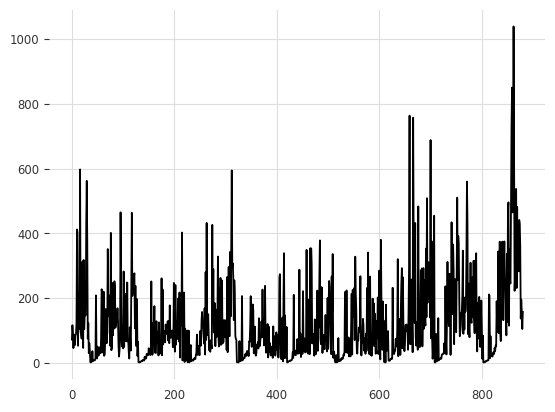

In [45]:
plotpred(predictions, actuals)

In [46]:
OTGCNmodel=modelTGCN("OTGCN", 6)
lossfun=nn.MSELoss()
OTGCNmodel, predtrain, acttrain=train_model(OTGCNmodel, 10, lossfun, train_dataset1)
OTGCNmodel, loss, predictions, probabilities, actuals= eval_model(OTGCNmodel, lossfun, test_dataset1)


Epoch [1/10] - Average Loss: 0.0808
Epoch [2/10] - Average Loss: 0.0808
Epoch [3/10] - Average Loss: 0.0808
Epoch [4/10] - Average Loss: 0.0808
Epoch [5/10] - Average Loss: 0.0808
Epoch [6/10] - Average Loss: 0.0808
Epoch [7/10] - Average Loss: 0.0808
Epoch [8/10] - Average Loss: 0.0808
Epoch [9/10] - Average Loss: 0.0808
Epoch [10/10] - Average Loss: 0.0808
MSE: 0.0704
Test Set - MSE: 0.0001
Test Set - RMSE: 0.0089


In [ ]:

torch.save(OTGCNmodel.state_dict(), 'Untitled Folder/Omodel.zip')

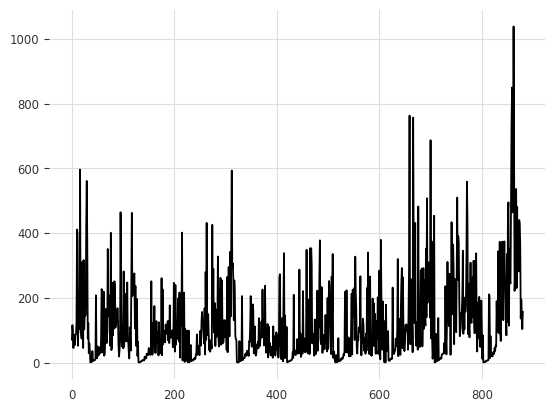

In [47]:
plotpred(predictions, actuals)


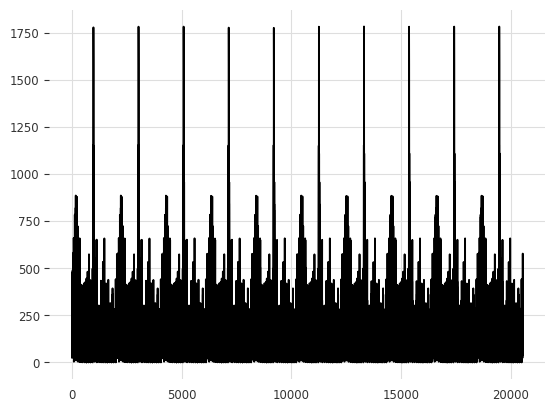

In [48]:
plotpred(predtrain, acttrain)


In [50]:
Geomodel

TemporalGCN(
  (conv1): TGCN(
    (conv_z): GCNConv(7, 2)
    (linear_z): Linear(in_features=4, out_features=2, bias=True)
    (conv_r): GCNConv(7, 2)
    (linear_r): Linear(in_features=4, out_features=2, bias=True)
    (conv_h): GCNConv(7, 2)
    (linear_h): Linear(in_features=4, out_features=2, bias=True)
  )
  (conv2): TGCN(
    (conv_z): GCNConv(2, 2)
    (linear_z): Linear(in_features=4, out_features=2, bias=True)
    (conv_r): GCNConv(2, 2)
    (linear_r): Linear(in_features=4, out_features=2, bias=True)
    (conv_h): GCNConv(2, 2)
    (linear_h): Linear(in_features=4, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.3, inplace=False)
)

In [53]:
    results1=[]
    results2=[]
    for i in range(0,1):
        Geomodel = modelTGCN("TGCN", 7)
        lossfun=nn.MSELoss()
        Geomodel, predictions, actuals=train_model(Geomodel, 10, lossfun, train_dataset2)
        Geomodel, loss, predictions, probabilities, actuals= eval_model(Geomodel, lossfun, test_dataset2)
        results1.append(loss)
        Geomodel, predictions, actuals=train_model(Geomodel, 10, lossfun, train_dataset3)
        Geomodel, loss, predictions2, probabilities2, actuals2= eval_model(Geomodel, lossfun, test_dataset3)
        
        results2.append(loss)
#runme(train_dataset2, test_dataset2, train_dataset3, test_dataset3)

Epoch [1/10] - Average Loss: 0.0858
Epoch [2/10] - Average Loss: 0.0842
Epoch [3/10] - Average Loss: 0.0832
Epoch [4/10] - Average Loss: 0.0824
Epoch [5/10] - Average Loss: 0.0818
Epoch [6/10] - Average Loss: 0.0814
Epoch [7/10] - Average Loss: 0.0811
Epoch [8/10] - Average Loss: 0.0810
Epoch [9/10] - Average Loss: 0.0809
Epoch [10/10] - Average Loss: 0.0808
MSE: 0.0708
Test Set - MSE: 0.0001
Test Set - RMSE: 0.0092
Epoch [1/10] - Average Loss: 0.0808
Epoch [2/10] - Average Loss: 0.0808
Epoch [3/10] - Average Loss: 0.0808
Epoch [4/10] - Average Loss: 0.0808
Epoch [5/10] - Average Loss: 0.0808
Epoch [6/10] - Average Loss: 0.0808
Epoch [7/10] - Average Loss: 0.0808
Epoch [8/10] - Average Loss: 0.0808
Epoch [9/10] - Average Loss: 0.0808
Epoch [10/10] - Average Loss: 0.0808
MSE: 0.0708
Test Set - MSE: 0.0001
Test Set - RMSE: 0.0092


In [ ]:
plotpreds(predictions2, actuals2)

In [54]:
#def runme(train_dataset2, test_dataset2, train_dataset3, test_dataset3):
results1=[]
results2=[]
for i in range(0,1):
    Geomodel = modelTGCN("TGCN", 7)
    lossfun=nn.L1Loss()
    Geomodel, predictions, actuals=train_model(Geomodel, 10, lossfun, train_dataset2)
    Geomodel, loss, predictions, probabilities, actuals= eval_model(Geomodel, lossfun, test_dataset2)
    results1.append(loss)
    Geomodel, predictions, actuals =train_model(Geomodel, 10, lossfun, train_dataset3)
    Geomodel, loss, predictions2, probabilities2, actuals= eval_model(Geomodel, lossfun, test_dataset3)
    results2.append(loss)
#runme(train_dataset2, test_dataset2, train_dataset3, test_dataset3)

Epoch [1/10] - Average Loss: 0.1496
Epoch [2/10] - Average Loss: 0.1304
Epoch [3/10] - Average Loss: 0.1135
Epoch [4/10] - Average Loss: 0.1012
Epoch [5/10] - Average Loss: 0.0902
Epoch [6/10] - Average Loss: 0.0797
Epoch [7/10] - Average Loss: 0.0691
Epoch [8/10] - Average Loss: 0.0577
Epoch [9/10] - Average Loss: 0.0461
Epoch [10/10] - Average Loss: 0.0435
MSE: 0.0395
Test Set - MSE: 0.0000
Test Set - RMSE: 0.0068
Epoch [1/10] - Average Loss: 0.0435
Epoch [2/10] - Average Loss: 0.0434
Epoch [3/10] - Average Loss: 0.0433
Epoch [4/10] - Average Loss: 0.0433
Epoch [5/10] - Average Loss: 0.0433
Epoch [6/10] - Average Loss: 0.0433
Epoch [7/10] - Average Loss: 0.0433
Epoch [8/10] - Average Loss: 0.0433
Epoch [9/10] - Average Loss: 0.0433
Epoch [10/10] - Average Loss: 0.0432
MSE: 0.0395
Test Set - MSE: 0.0000
Test Set - RMSE: 0.0068


In [79]:
Oppsallneighbors = modelTGCN("TGCN", 7)
Oppsallneighbors, predictions, actuals=train_model(Oppsallneighbors, 10, lossfun, train_dataset3)
Oppsallneighbors,  loss, predictions2, probabilities2, actuals= eval_model(Oppsallneighbors, lossfun, test_dataset3)
torch.save(Oppsallneighbors.state_dict(), 'Untitled Folder/Oppsallneighbors.zip')

Epoch [1/10] - Average Loss: 0.0717
Epoch [2/10] - Average Loss: 0.0619
Epoch [3/10] - Average Loss: 0.0529
Epoch [4/10] - Average Loss: 0.0468
Epoch [5/10] - Average Loss: 0.0460
Epoch [6/10] - Average Loss: 0.0455
Epoch [7/10] - Average Loss: 0.0451
Epoch [8/10] - Average Loss: 0.0448
Epoch [9/10] - Average Loss: 0.0444
Epoch [10/10] - Average Loss: 0.0441
MSE: 0.0395
Test Set - MSE: 0.0000
Test Set - RMSE: 0.0068


In [80]:
y_pred=(scalar.inverse_transform((np.asarray(predictions[i]).reshape(-1, 1))))
y_test=(scalar.inverse_transform((np.asarray(actuals[i]).reshape(-1, 1))))

results_df = pd.DataFrame({'Actual Delay': y_test, 'Predicted Delay': y_pred})
results=results_df.iloc[1:1000]
x = np.arange(len(results))
plt.plot(x, results['Actual Delay'], label='Actual Delay', color="blue")
plt.plot(x, results['Predicted Delay'], label='Predicted Delay', color="red")
plt.xlabel('Instance')
plt.ylabel('Delay')
plt.title('Actual vs Predicted Delay')
plt.ylim(0, 500)
plt.legend()
plt.show()

ValueError: Per-column arrays must each be 1-dimensional

In [ ]:

import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GConvGRU

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, filters, 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

from tqdm import tqdm

model = RecurrentGCN(node_features=6, filters=32)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in range(10):
    cost = 0
    costs=[]
    for time, snapshot in enumerate(train_dataset1):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = torch.mean((y_hat-snapshot.y)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()
    print("MSE: {:.4f}".format(cost))


model.eval()
cost = 0
for time, snapshot in enumerate(test_dataset1):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))




In [57]:
flights=df[["ORIGIN_AIRPORT_ID", "DEST_AIRPORT_ID", "DEP_DELAY", "corrected_Dep", "T_Group", "NORMED_DEP"]]


In [82]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split



y = flights['NORMED_DEP']
data = flights.drop(['DEP_DELAY', "NORMED_DEP"], axis=1)
X =data.select_dtypes(include=['int', 'float']).values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.4, random_state=42)

In [68]:
from sklearn.ensemble import RandomForestRegressor

model2 = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
model2.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, random_state=42)

In [69]:
from sklearn.metrics import mean_squared_error, r2_score


accuracy = model2.score(X_test, y_test)
print("Model Accuracy:", accuracy)
y_pred = model2.predict(X_test)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

Model Accuracy: 0.09590158553320538
Mean squared error: 1577.03
Coefficient of determination: 0.10


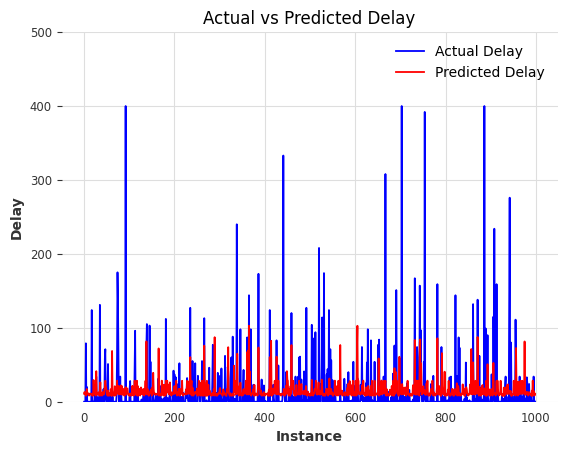

In [70]:
results_df = pd.DataFrame({'Actual Delay': y_test, 'Predicted Delay': y_pred})
results=results_df.iloc[1:1000]
x = np.arange(len(results))
plt.plot(x, results['Actual Delay'], label='Actual Delay', color="blue")
plt.plot(x, results['Predicted Delay'], label='Predicted Delay', color="red")
plt.xlabel('Instance')
plt.ylabel('Delay')
plt.title('Actual vs Predicted Delay')
plt.ylim(0, 500)
plt.legend()
plt.show()

In [83]:
from sklearn.ensemble import GradientBoostingRegressor


model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=67)
model.fit(X_train, y_train)
accuracy = model.score(X_test, y_test)
print("Model Accuracy:", accuracy)
y_pred = model.predict(X_test)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

Model Accuracy: 0.13488729553911594
Mean squared error: 1509.02
Coefficient of determination: 0.13


In [86]:
math.sqrt(mean_squared_error(y_test, y_pred))

38.84616352808763

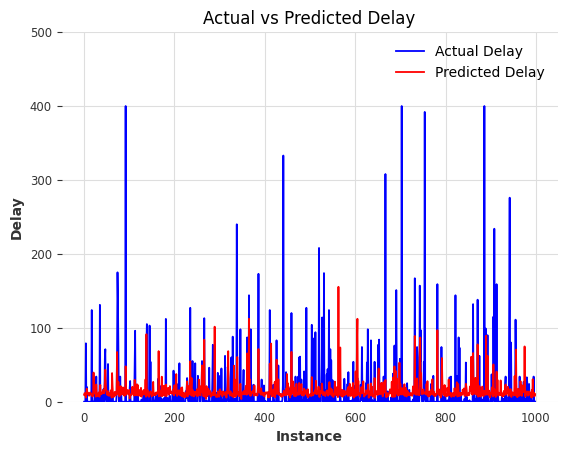

In [74]:
results_df = pd.DataFrame({'Actual Delay': y_test, 'Predicted Delay': y_pred})
results=results_df.iloc[1:1000]
x = np.arange(len(results))
plt.plot(x, results['Actual Delay'], label='Actual Delay', color="blue")
plt.plot(x, results['Predicted Delay'], label='Predicted Delay', color="red")
plt.xlabel('Instance')
plt.ylabel('Delay')
plt.title('Actual vs Predicted Delay')
plt.ylim(0, 500)
plt.legend()
plt.show()